Epoch 1/5


2024-03-11 12:38:46.935008: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


378/388 [============================>.] - ETA: 0s - loss: 5.5006
Epoch 1: val_loss improved from inf to 0.63111, saving model to 2-MIB_TimeStep24_Future3/model.h5
388/388 [==============================] - 2s 3ms/step - loss: 5.4115 - val_loss: 0.6311 - lr: 0.0010
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 3.2126
Epoch 2: val_loss improved from 0.63111 to 0.33977, saving model to 2-MIB_TimeStep24_Future3/model.h5
388/388 [==============================] - 1s 3ms/step - loss: 3.2126 - val_loss: 0.3398 - lr: 0.0010
Epoch 3/5
371/388 [===========================>..] - ETA: 0s - loss: 2.6311
Epoch 3: val_loss improved from 0.33977 to 0.26591, saving model to 2-MIB_TimeStep24_Future3/model.h5
388/388 [==============================] - 1s 3ms/step - loss: 2.6504 - val_loss: 0.2659 - lr: 0.0010
Epoch 4/5
385/388 [============================>.] - ETA: 0s - loss: 2.3763
Epoch 4: val_loss did not improve from 0.26591
388/388 [==============================] - 1s 3ms/s

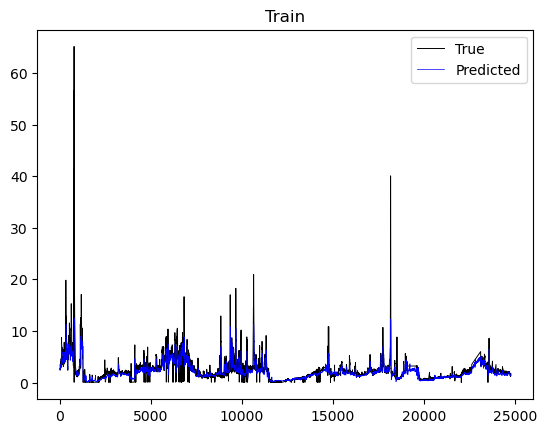

45/45 [==============================] - 0s 961us/step


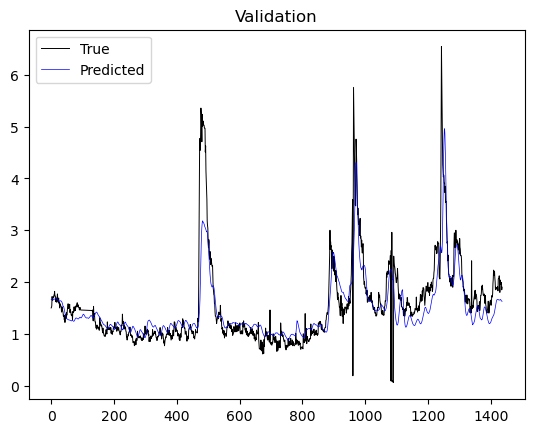

274/274 [==============================] - 0s 703us/step


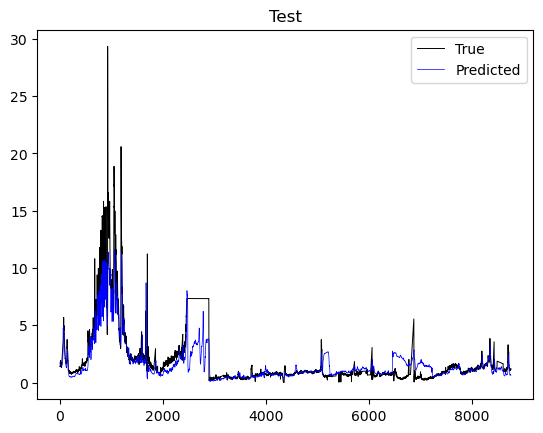

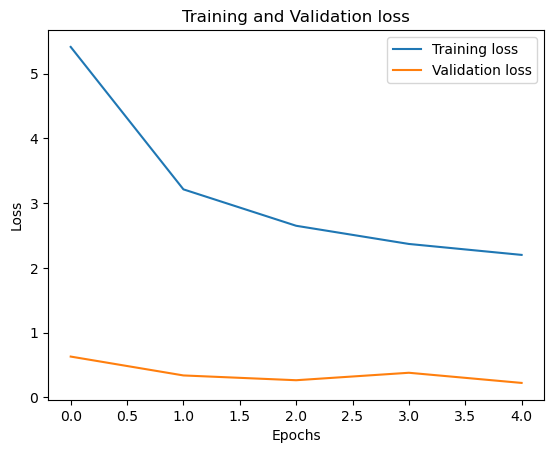

In [6]:

# LSTMモデルを使用して時系列データを処理し、訓練、検証、テストデータセット上で予測を行う


# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# データの読み込み
df1 = pd.read_csv('./csv/train.csv')
df2 = pd.read_csv('./csv/val.csv')
df3 = pd.read_csv('./csv/test.csv')

# ハイパーパラメータの設定
wtp = '2-MIB'
time_steps = 24
future = 3
n_in = 8  # 入力層のノード数は特徴量の数に等しい
n_hidden = 16  # 隠れ層のノード数
n_out = 1  # 出力層のノード数
epochs = 5
batch_size = 64

if wtp == '2-MIB':
    df1 = df1.drop('geosmin', axis=1)
    df2 = df2.drop('geosmin', axis=1)
    df3 = df3.drop('geosmin', axis=1)  
elif wtp == 'geosmin':
    df1 = df1.drop('2-MIB', axis=1)
    df2 = df2.drop('2-MIB', axis=1)
    df3 = df3.drop('2-MIB', axis=1)
    

data1 = []
target1 = []
data2 = []
target2 = []
data3 = []
target3 = []


# inputは標準化するけど、outputは標準化しないので、2つ用意
df11 = df1[['turbidity', 'pH', 'alkalinity', 'conductivity', 'cl', 'temperature', 'river', wtp]].dropna()
df_save = df11
df1 = df1[[wtp]].dropna()
df11 = (df11 - df_save.min()) / (df_save.max() - df_save.min())


# LSTMのデータの型に変更
for i in range(len(df11) - time_steps - future):
    data1.append(df11.values[i: i + time_steps])
for i in range(len(df1) - time_steps - future):
    target1.append(df1.values[i + time_steps + future])

# dataはinput。標準化したものを使用
x_train = np.array(data1)

y_train = np.array(target1)

# データの整形
x_train = x_train.reshape(len(x_train), time_steps, n_in)
y_train = y_train.reshape(len(y_train), n_out)


df22 = df2[['turbidity', 'pH', 'alkalinity', 'conductivity', 'cl', 'temperature', 'river', wtp]].dropna()
df2 = df2[[wtp]].dropna()
df22 = (df22 - df_save.min()) / (df_save.max() - df_save.min())


# データを箱に入れる
for i in range(len(df22) - time_steps - future):
    data2.append(df22.values[i: i + time_steps])

for i in range(len(df2) - time_steps - future):
    target2.append(df2.values[i + time_steps + future])

# dataはinput。標準化したものを使用
x_val = np.array(data2)

# targetはoutput
y_val = np.array(target2)

# データの整形
x_val = x_val.reshape(len(x_val), time_steps, n_in)
y_val = y_val.reshape(len(y_val), n_out)

# inputは標準化するけど、outputは標準化しないので、2つ用意
df33 = df3[['turbidity', 'pH', 'alkalinity', 'conductivity', 'cl', 'temperature', 'river', wtp]].dropna()
df3 = df3[[wtp]].dropna()
df33 = (df33 - df_save.min()) / (df_save.max() - df_save.min())

# データを箱に入れる
for i in range(len(df33) - time_steps - future):
    data3.append(df33.values[i: i + time_steps])

for i in range(len(df3) - time_steps - future):
    target3.append(df3.values[i + time_steps + future])

# dataはinput。標準化したものを使用
x_test = np.array(data3)

# targetはoutput
y_test = np.array(target3)

# データの整形
x_test = x_test.reshape(len(x_test), time_steps, n_in)
y_test = y_test.reshape(len(y_test), n_out)



# モデルの定義
input_layer = Input(shape=(time_steps, n_in))
x = LSTM(n_hidden)(input_layer)
output_layer = Dense(n_out, name="Output_Layer")(x)
model = Model(inputs=input_layer, outputs=output_layer)

# コンパイル
optimizer = Adam(lr=0.001)
model.compile(loss="mse", optimizer=optimizer)

# コールバックの定義
ES = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
new_folder = f"{wtp}_TimeStep{time_steps}_Future{future}"
os.makedirs(new_folder, exist_ok=True)  # モデル保存用フォルダの作成
model_checkpoint = ModelCheckpoint(filepath=os.path.join(new_folder, 'model.h5'), monitor='val_loss', save_best_only=True, verbose=1)

# モデルの訓練
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(x_val, y_val), 
                    callbacks=[ES, reduce_lr, model_checkpoint])


open(new_folder + '/' + 'model.json', "w").write(model.to_json())
model.save_weights(new_folder + '/' + 'last_model.h5')

json_file = open(new_folder + '/' + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

weightPath = new_folder + '/' + 'model.h5'
if not os.path.exists(new_folder):
    model.load_weights(new_folder + '/' + 'last_model.h5')
else:
    model.load_weights(new_folder + '/' + 'model.h5')

# 結果の可視化
def plot_results(y_true, y_pred, label, folder, file_name):
    plt.plot(y_true, label='True', color='black', linewidth=0.7)
    plt.plot(y_pred, label='Predicted', color='blue', linewidth=0.5)
    plt.title(label)
    plt.legend()
    plt.savefig(os.path.join(folder, file_name))
    plt.show()

plot_results(y_train, model.predict(x_train), 'Train', new_folder, 'LSTM_train.pdf')
plot_results(y_val, model.predict(x_val), 'Validation', new_folder, 'LSTM_val.pdf')
plot_results(y_test, model.predict(x_test), 'Test', new_folder, 'LSTM_test.pdf')

# 損失と検証損失のプロット
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(new_folder, 'LSTM_loss_epochs.pdf'))
plt.show()
